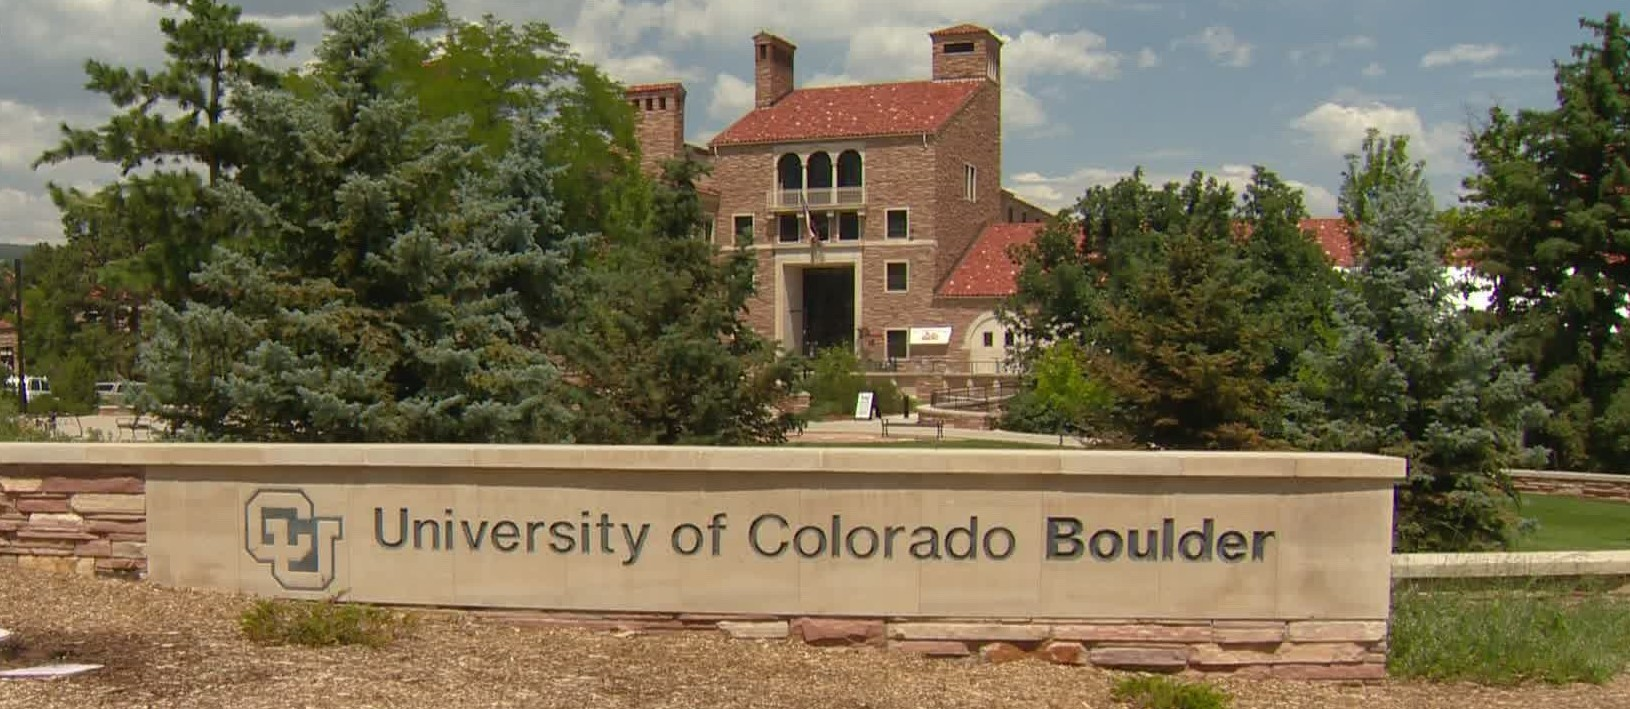

# Building Recommender Systems for Movie Rating Prediction

In this assignment, we will build a recommender systems that predict movie ratings. [MovieLense](https://grouplens.org/datasets/movielens/) has currently 25 million user-movie ratings.  Since the entire data is too big, we use  a 1 million ratings subset [MovieLens 1M](https://www.kaggle.com/odedgolden/movielens-1m-dataset), and we reformatted the data to make it more convenient to use.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 
from pytest import approx
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import NMF
import itertools # For iteration over found categories and assign best match
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
MV_users = pd.read_csv('data/users.csv')
MV_movies = pd.read_csv('data/movies.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
from collections import namedtuple
Data = namedtuple('Data', ['users','movies','train','test'])
data = Data(MV_users, MV_movies, train, test)

I used the code of week 3 assignement as base and added a function predict_nmf to predict with non-negative matrix factorization 

In [4]:
# Helper function to find best matching labels sequence
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """

    labels = np.unique(ytdf)
    acc = list()
    #permutations = list(itertools.permutations(range(n)))
    permutations = list(itertools.permutations([1,2,3,4,5]))
    for permut in permutations:
        acc.append(accuracy_score(yp.replace(labels, permut), ytdf))
    return permutations[acc.index(max(acc))], max(acc)

In [5]:
class RecSys():
    def __init__(self,data):
        self.data=data
        self.allusers = list(self.data.users['uID'])
        self.allmovies = list(self.data.movies['mID'])
        self.genres = list(self.data.movies.columns.drop(['mID', 'title', 'year']))
        self.mid2idx = dict(zip(self.data.movies.mID,list(range(len(self.data.movies)))))
        self.uid2idx = dict(zip(self.data.users.uID,list(range(len(self.data.users)))))
        self.Mr=self.rating_matrix()
        self.Mm=None #movie_feature_matrix
        self.sim=np.zeros((len(self.allmovies),len(self.allmovies)))
        
    def rating_matrix(self):
        """
        Convert the rating matrix to numpy array of shape (#allusers,#allmovies)
        """
        ind_movie = [self.mid2idx[x] for x in self.data.train.mID] 
        ind_user = [self.uid2idx[x] for x in self.data.train.uID]
        rating_train = list(train.rating)
        return np.array(coo_matrix((rating_train, (ind_user, ind_movie)), shape=(len(self.allusers), len(self.allmovies))).toarray())

    def predict_everything_to_3(self):
        """
        Predict everything to 3 for the test data
        """
        return np.full(self.data.test.rating.shape, 3)
        
    def predict_to_user_average(self):
        """
        Predict to average rating for the user.
        Returns numpy array of shape (#users,)
        """
        av_ratings = self.data.test.copy()
        for uID in self.allusers:
            #av_ratings.rating[av_ratings.uID == uID] = np.nanmean(self.data.test.rating[self.data.test.uID == uID])
            # get User index from ID
            uidx = self.uid2idx[uID]
            av_ratings.rating[av_ratings.uID == uID] = np.mean(self.Mr[uidx][self.Mr[uidx] > 0])

        return av_ratings.rating
    
    def rmse(self,yp):
        yp[np.isnan(yp)]=3 #In case there is nan values in prediction, it will impute to 3.
        yt=np.array(self.data.test.rating)
        return np.sqrt(((yt-yp)**2).mean())

class ContentBased(RecSys):
    def __init__(self,data):
        super().__init__(data)
        self.data=data
        self.Mm = self.calc_movie_feature_matrix()
        
    def calc_movie_feature_matrix(self):
        """
        Create movie feature matrix in a numpy array of shape (#allmovies, #genres) 
        """
        # your code here
        return (np.array(self.data.movies.drop(['mID', 'title', 'year'],axis=1)))      
    
    def predict_nmf(self):

        # train on all genges of all movies and try to get 5 classes (for ratings)
        nmf = NMF(n_components=5, random_state=1, alpha=0, l1_ratio=0).fit(self.Mm)
        
        # read trainset
        nmf_train = self.data.train.copy()
        
        # get movie genres
        nmf_genres = self.data.movies.copy()
        
        # join in on dataframe
        nmf_train = nmf_train.join(nmf_genres.set_index('mID'), on='mID')
        
        # drop not needed columns
        nmf_train = nmf_train.drop(columns=['title', 'year'])
        
        # make prediction
        y_predict_prob = nmf.transform(nmf_train.drop(columns=['uID', 'mID', 'rating']))
            
        # index with highest probability is our predicted class (add 1 because 0 is not rated)
        y_predict = np.argmax(y_predict_prob, axis=1)+1
            
        # create dataframe
        y_predictdf = pd.DataFrame(y_predict)
        
        # check best labelorder
        labelorder, acc = label_permute_compare(nmf_train.rating[nmf_train.rating > 0], y_predictdf)

        # assign best labelorder to prediction
        y_predictdf = y_predictdf.replace(np.unique(y_predictdf), labelorder)        

        # read testset
        nmf_test = self.data.test.copy()
        
        # join in on dataframe
        nmf_test = nmf_test.join(nmf_genres.set_index('mID'), on='mID')
        
        # drop not needed columns
        nmf_test = nmf_test.drop(columns=['title', 'year'])
        
        # make prediction
        y_predict_prob = nmf.transform(nmf_test.drop(columns=['uID', 'mID', 'rating']))
            
        # index with highest probability is our predicted class (add 1 because 0 is not rated)
        y_predict = np.argmax(y_predict_prob, axis=1)+1
            
        # create dataframe
        y_predictdf = pd.DataFrame(y_predict)
        
        # assign best labelorder to prediction
        y_predictdf = y_predictdf.replace(np.unique(y_predictdf), labelorder)        

        return np.array(y_predictdf).flatten()


In [6]:
# tests predict_everything_to_3 in class RecSys
rs = RecSys(data)
yp = rs.predict_everything_to_3()
print(rs.rmse(yp))

1.2585510334053043


In [7]:
# tests predict_to_user_average in the class RecSys
yp = rs.predict_to_user_average()
print(rs.rmse(yp))

1.0352910334228138


In [9]:
cb = ContentBased(data)
# predict with non-negative matrix factorization 
ynmf = cb.predict_nmf()
print(rs.rmse(ynmf))

1.7025885929971738


I used NMF to find 5 clusters based on genres of all movies.

In next step I assigned the labels (cluster predictions) to the user ratings based best accuracy on trainset.

Finaly I created a prediction on testset with this model and label assignement.

As expected we get a worse performance based on mean squere error. Its even worser as average or user average.

Main reson is, that we get with unsupervised lerning probably a good clustering but there is no general impartial rule that a specific movie get a good or bad rating in general based on his genre. It depends on the user preference. But this would be supervised approach and is not part of NMF.

We could combine both approaches to get a better performance. One option which could lead to a better performance would be:
- take the NMF model trained on all movie genres to build clusters (unsupervised)
- than based on user preferences assign normalised ratings to these clusters (supervised)
- predict ratings based on theses user-ratings/cluster assignements
